# Hybrid RNN Model
This notebook contains a hybrid RNN model combining LSTM and GRU layers with Dropout and Batch Normalization.

## Подключаем библиотеки

In [1]:
!pip install chardet
import chardet

In [2]:
# Импорт необходимых библиотек
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dropout, BatchNormalization, Dense
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import load_model
import pickle
import seaborn as sns

## Работа с набором данных

In [3]:
# Загрузка и предобработка датасета
def load_and_preprocess_data(file_path):
    # Открываем файл в двоичном режиме и читаем данные
    with open(file_path, 'rb') as file:
        raw_data = file.read()
    # Используем chardet для определения кодировки
    result = chardet.detect(raw_data)
    # Получаем название кодировки
    encoding_file = result['encoding']
    print(f"Кодировка файла: {encoding_file}")

    # Загрузка данных
    data = pd.read_csv(file_path, encoding=encoding_file, delimiter=';')

    # Преобразование столбцов в соответствующие типы данных
    data['Temperature (¡C)'] = data['Temperature (¡C)'].str.replace(',', '.').astype(float)
    data['Pressure (mBar)'] = data['Pressure (mBar)'].str.replace(',', '.').astype(float)
    data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d.%m.%Y %H:%M')
    data.set_index('Datetime', inplace=True)

    # Заполнение пропущенных значений
    for column in data.columns:
        if pd.api.types.is_numeric_dtype(data[column]):
            data[column].fillna(data[column].mean(), inplace=True)

    # Разделение данных на обучающую, валидационную и тестовую выборки
    train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    return train_scaled, val_scaled, test_scaled, scaler, test_data

In [4]:
# Создание датасета для RNN
def create_rnn_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])  # Предсказание только уровня радона
    return np.array(dataX), np.array(dataY)

## Определение модели

In [5]:
# Определение гибридной модели
def create_hybrid_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(32, return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
    return model

## Визуализация
### Визуализация истории обучения

In [6]:
# Визуализация истории обучения
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Потери модели по эпохам')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Визуализация истории обучения
def plot_mae_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Потери модели по эпохам')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
# Визуализация истории обучения
def plot_mape_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mape'], label='MAPE')
    plt.plot(history.history['val_mape'], label='Validation MAPE')
    plt.title('Потери модели по эпохам')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)
    plt.show()

### Визуализация сравнения предсказания

In [9]:
# Функция для визуализации истинных и прогнозируемых значений
def plot_true_vs_predicted(true_series, predicted_series):
    fig = go.Figure()

    # Добавить строку для фактических уровней радона
    fig.add_trace(go.Scatter(
        x=true_series.index,
        y=true_series,
        mode='lines',
        name='Actual Radon Level'
    ))

    # Добавить маркер для прогнозируемого уровня радона с hovertemplate
    fig.add_trace(go.Scatter(
        x=predicted_series.index,
        y=predicted_series,
        mode='markers',
        name='Predicted Radon Level',
        hovertemplate=(
            'Date: %{x|%Y-%m-%d %H:%M:%S}<br>' +
            'Predicted: %{y:.2f}<br>' +
            'Actual: %{customdata:.2f}<br>' +
            'Actual Date: %{x|%Y-%m-%d %H:%M:%S}<extra></extra>'
        ),
        customdata=true_series
    ))

    # Добавить заголовок и метки осей
    fig.update_layout(
        title='Predicted vs Actual Radon Level',
        xaxis_title='Datetime',
        yaxis_title='Radon (Bq.m3)'
    )

    fig.show()

## Сохранение модели и истории обучения

In [10]:
# Сохранение обученной модели
def save_model(model, model_path):
    """
    Сохраняет обученную модель на диск.

    :param model: Обученная модель Keras
    :param model_path: Путь для сохранения модели
    """
    model.save(model_path)
    print(f"Модель сохранена в {model_path}")

In [11]:
# Сохранение истории обучения
def save_training_history(history, history_path):
    """
    Сохраняет историю обучения модели в файл.

    :param history: Объект истории обучения, возвращаемый model.fit()
    :param history_path: Путь для сохранения истории
    """
    with open(history_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
    print(f"История обучения сохранена в {history_path}")

## Работа модели

In [12]:
file_path = '/content/data.csv'  # Путь к файлу с данными
train_scaled, val_scaled, test_scaled, scaler, test_data = load_and_preprocess_data(file_path)

Кодировка файла: ISO-8859-1


<ipython-input-3-714fd4c502a4>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mean(), inplace=True)


In [13]:
time_step = 72
X_train, y_train = create_rnn_dataset(train_scaled, time_step)
X_val, y_val = create_rnn_dataset(val_scaled, time_step)
X_test, y_test = create_rnn_dataset(test_scaled, time_step)

In [14]:
# Изменение формы входных данных
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], train_scaled.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], val_scaled.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], test_scaled.shape[1])

In [15]:
# Создание и обучение модели
model = create_hybrid_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 117ms/step - loss: 0.7465 - mae: 0.3267 - mape: 56716.2500 - val_loss: 0.2089 - val_mae: 0.2179 - val_mape: 151.8460
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 34s 84ms/step - loss: 0.1746 - mae: 0.2001 - mape: 104178.2578 - val_loss: 0.1016 - val_mae: 0.1877 - val_mape: 173.1032
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - loss: 0.0967 - mae: 0.1900 - mape: 39272.2383 - val_loss: 0.0729 - val_mae: 0.1895 - val_mape: 171.6779
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - loss: 0.0723 - mae: 0.1902 - mape: 64289.7891 - val_loss: 0.0614 - val_mae: 0.1812 - val_mape: 181.9180
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - loss: 0.0625 - mae: 0.1887 - mape: 20863.8262 - val_loss: 0.0564 - val_mae: 0.1860 - val_mape: 177.1102
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - loss: 0.0572 - mae: 0.1872 - mape: 33430.0469 - val_loss: 0.0536 - val_mae: 0.1797 - val_mape: 182.5249
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━

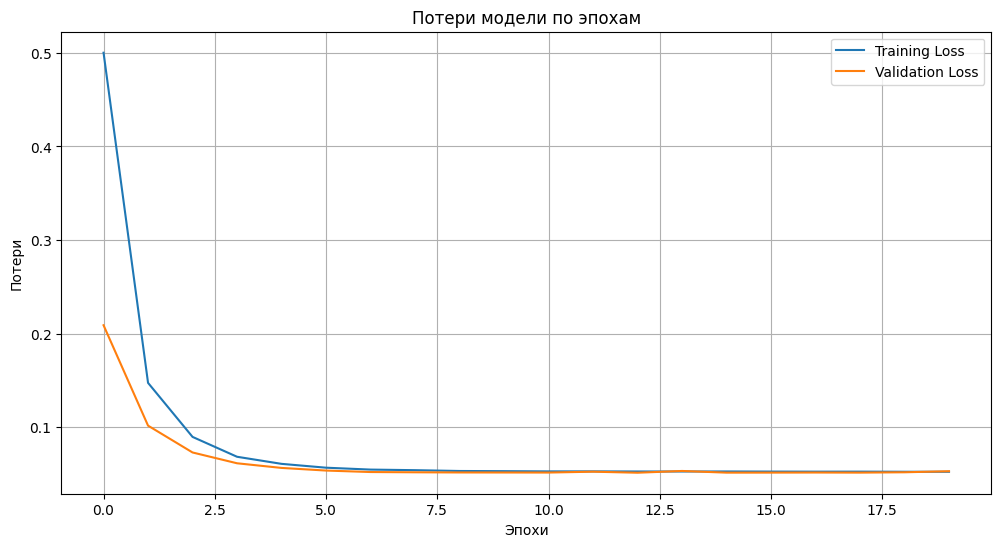

In [16]:
# Визуализация истории обучения
plot_training_history(history)

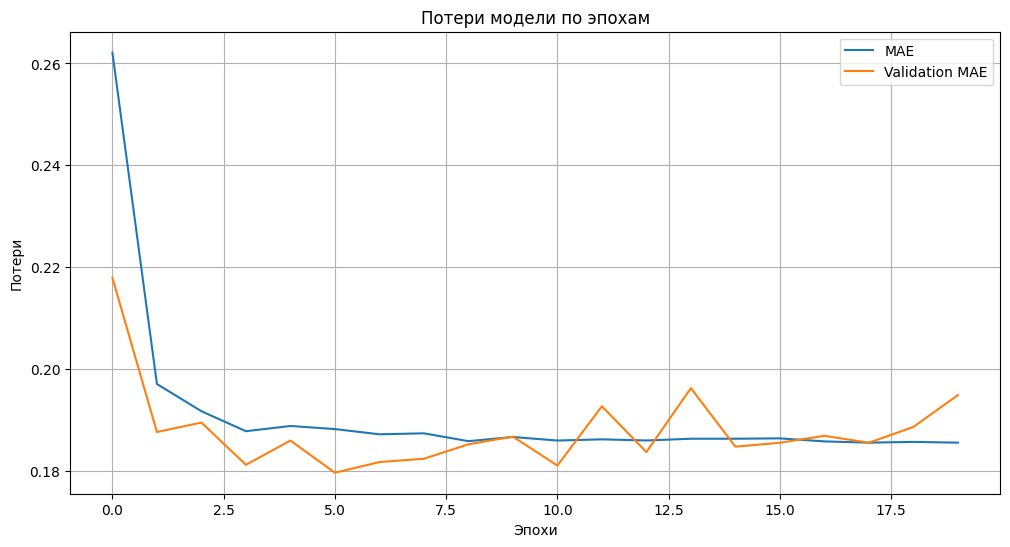

In [17]:
plot_mae_history(history)

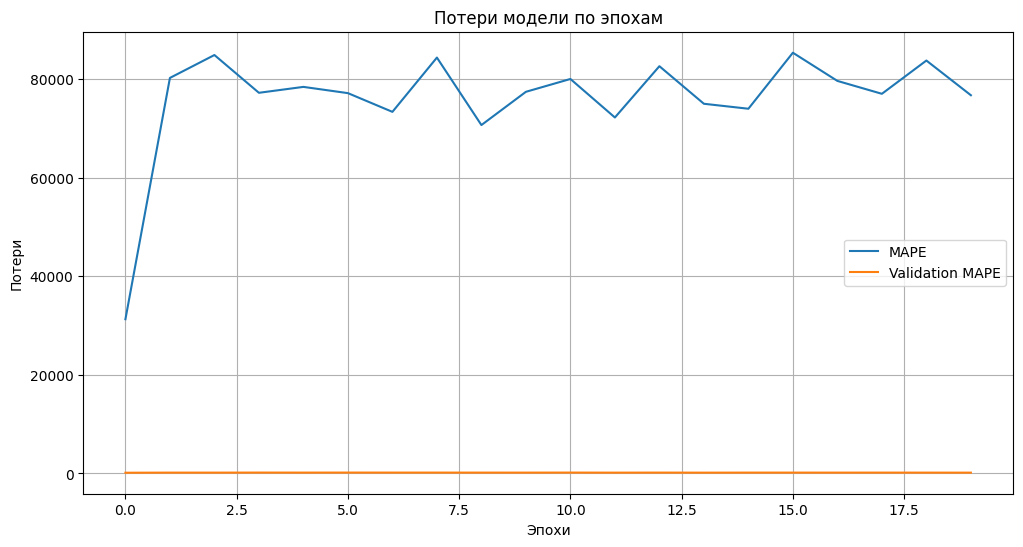

In [18]:
plot_mape_history(history)

In [19]:
# Evaluate the model
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}, Test MAPE: {test_mape}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0528 - mae: 0.1939 - mape: 168.7777
Test Loss: 0.052776824682950974, Test MAE: 0.19356828927993774, Test MAPE: 178.86582946777344


In [20]:
# Оценка модели
test_loss, test_mae, test_mape = model.evaluate(X_test, y_test, verbose=1)
print(f'Потери на тесте: {test_loss}, MAE на тесте: {test_mae}, MAPE на тесте: {test_mape}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0528 - mae: 0.1939 - mape: 168.7777
Потери на тесте: 0.052776824682950974, MAE на тесте: 0.19356828927993774, MAPE на тесте: 178.86582946777344


In [21]:
# Получение предсказаний модели на тестовых данных
test_predictions = model.predict(X_test)

# Инвертирование масштабирования для получения реальных значений
def invert_scaling(scaled_value, scaler, column_index=0):
    # Создаем пустой массив размерности исходных данных
    dummy = np.zeros((len(scaled_value), scaler.scale_.shape[0]))
    # Заполняем столбец с целевой переменной масштабированными значениями
    dummy[:, column_index] = scaled_value
    # Инвертируем масштабирование
    return scaler.inverse_transform(dummy)[:, column_index]

# Инвертируем масштабирование для истинных и предсказанных значений
y_test_inv = invert_scaling(y_test, scaler)
test_pred_inv = invert_scaling(test_predictions.flatten(), scaler)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


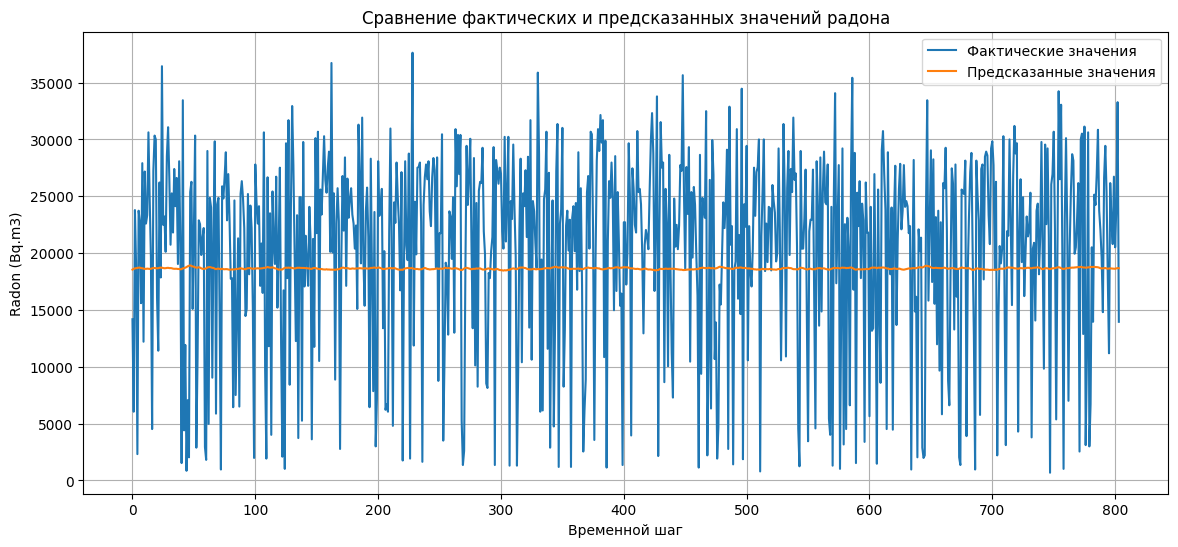

In [22]:
# Визуализация фактических vs предсказанных значений
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='Фактические значения')
plt.plot(test_pred_inv, label='Предсказанные значения')
plt.title('Сравнение фактических и предсказанных значений радона')
plt.xlabel('Временной шаг')
plt.ylabel('Radon (Bq.m3)')
plt.legend()
plt.grid(True)
plt.show()

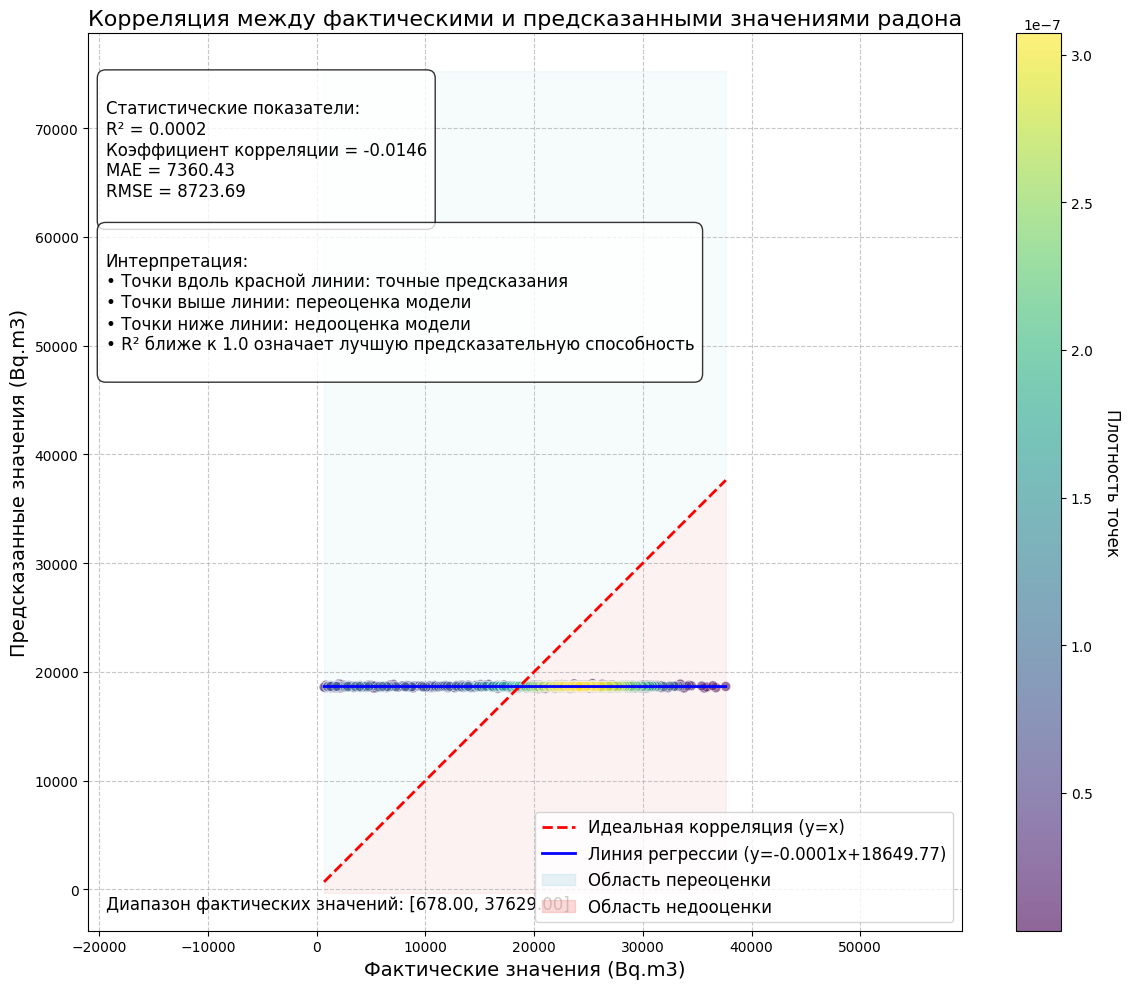

Процент предсказаний с относительной ошибкой ≤10%: 13.56%
Процент предсказаний с относительной ошибкой ≤20%: 30.97%
Процент предсказаний с относительной ошибкой ≤30%: 53.48%


In [23]:
# График рассеяния для проверки корреляции между фактическими и предсказанными значениями
from scipy import stats
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 10))

# Добавляем градиентную окраску точек по плотности для лучшей визуализации
from scipy.stats import gaussian_kde
xy = np.vstack([y_test_inv, test_pred_inv])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = y_test_inv[idx], test_pred_inv[idx], z[idx]

# Создаем основной график рассеяния с градиентной окраской
scatter = plt.scatter(x, y, c=z, s=50, alpha=0.6, cmap='viridis', edgecolor='w', linewidth=0.5)

# Линия идеальной корреляции
ideal_line, = plt.plot([y_test_inv.min(), y_test_inv.max()],
                      [y_test_inv.min(), y_test_inv.max()],
                      'r--', linewidth=2, label='Идеальная корреляция (y=x)')

# Добавляем линию регрессии
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_inv, test_pred_inv)
regression_line, = plt.plot(
    [y_test_inv.min(), y_test_inv.max()],
    [slope*y_test_inv.min() + intercept, slope*y_test_inv.max() + intercept],
    'b-', linewidth=2,
    label=f'Линия регрессии (y={slope:.4f}x+{intercept:.2f})'
)

# Добавляем цветовую шкалу
cbar = plt.colorbar(scatter)
cbar.set_label('Плотность точек', rotation=270, labelpad=20, fontsize=12)

# Добавляем статистическую информацию
r_squared = r_value**2
mae = np.mean(np.abs(y_test_inv - test_pred_inv))
rmse = np.sqrt(np.mean((y_test_inv - test_pred_inv)**2))

stats_text = f"""
Статистические показатели:
R² = {r_squared:.4f}
Коэффициент корреляции = {r_value:.4f}
MAE = {mae:.2f}
RMSE = {rmse:.2f}
"""

plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
             fontsize=12, verticalalignment='top')

# Добавляем примечания по интерпретации
interpretation_text = """
Интерпретация:
• Точки вдоль красной линии: точные предсказания
• Точки выше линии: переоценка модели
• Точки ниже линии: недооценка модели
• R² ближе к 1.0 означает лучшую предсказательную способность
"""

plt.annotate(interpretation_text, xy=(0.02, 0.78), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
             fontsize=12, verticalalignment='top')

# Выделяем области переоценки и недооценки
overestimation = mpatches.Patch(color='lightblue', alpha=0.3, label='Область переоценки')
underestimation = mpatches.Patch(color='lightcoral', alpha=0.3, label='Область недооценки')

# Добавляем полупрозрачные области для визуализации переоценки/недооценки
plt.fill_between([y_test_inv.min(), y_test_inv.max()],
                 [y_test_inv.min(), y_test_inv.max()],
                 [y_test_inv.max()*2, y_test_inv.max()*2],
                 color='lightblue', alpha=0.1)
plt.fill_between([y_test_inv.min(), y_test_inv.max()],
                 [y_test_inv.min(), y_test_inv.max()],
                 [y_test_inv.min()*-0.5, y_test_inv.min()*-0.5],
                 color='lightcoral', alpha=0.1)

# Создаем легенду с добавленными элементами
plt.legend(handles=[ideal_line, regression_line, overestimation, underestimation],
           loc='lower right', fontsize=12)

# Добавляем названия осей и заголовок
plt.title('Корреляция между фактическими и предсказанными значениями радона', fontsize=16)
plt.xlabel('Фактические значения (Bq.m3)', fontsize=14)
plt.ylabel('Предсказанные значения (Bq.m3)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Устанавливаем одинаковый масштаб для осей
plt.axis('equal')
plt.tight_layout()

# Добавляем информацию о диапазоне значений
range_text = f"Диапазон фактических значений: [{y_test_inv.min():.2f}, {y_test_inv.max():.2f}]"
plt.annotate(range_text, xy=(0.02, 0.02), xycoords='axes fraction',
             fontsize=12, verticalalignment='bottom')

plt.show()

# Дополнительно выводим процент точек в пределах определенной погрешности
rel_error_10 = np.sum(np.abs((y_test_inv - test_pred_inv) / y_test_inv) <= 0.1) / len(y_test_inv) * 100
rel_error_20 = np.sum(np.abs((y_test_inv - test_pred_inv) / y_test_inv) <= 0.2) / len(y_test_inv) * 100
rel_error_30 = np.sum(np.abs((y_test_inv - test_pred_inv) / y_test_inv) <= 0.3) / len(y_test_inv) * 100

print(f"Процент предсказаний с относительной ошибкой ≤10%: {rel_error_10:.2f}%")
print(f"Процент предсказаний с относительной ошибкой ≤20%: {rel_error_20:.2f}%")
print(f"Процент предсказаний с относительной ошибкой ≤30%: {rel_error_30:.2f}%")

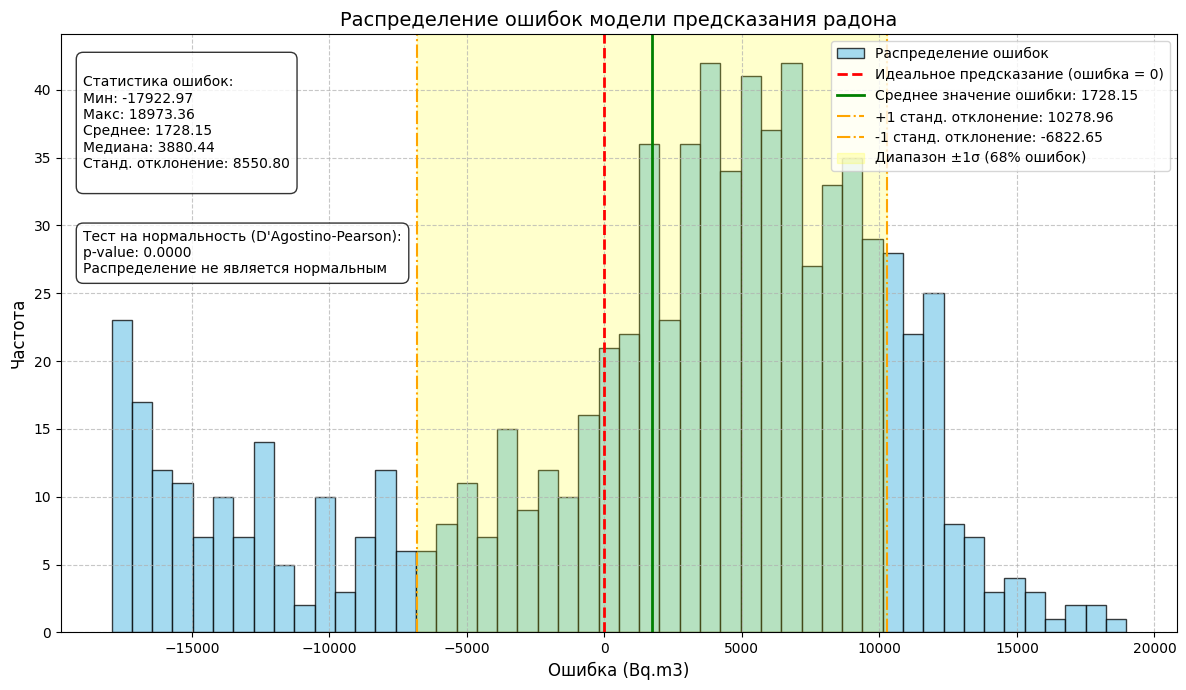

Процент ошибок в пределах ±1σ: 69.90%
Процент ошибок в пределах ±2σ: 92.79%
Процент ошибок в пределах ±3σ: 100.00%


In [24]:
# Гистограмма распределения ошибок
errors = y_test_inv - test_pred_inv
mean_error = np.mean(errors)
std_error = np.std(errors)

plt.figure(figsize=(12, 7))

# Создаем гистограмму с большим количеством бинов для детализации
n, bins, patches = plt.hist(errors, bins=50, alpha=0.75, color='skyblue',
                           edgecolor='black', label='Распределение ошибок')

# Добавляем вертикальные линии для ключевых статистик
plt.axvline(x=0, color='r', linestyle='--', linewidth=2,
           label='Идеальное предсказание (ошибка = 0)')
plt.axvline(x=mean_error, color='green', linestyle='-', linewidth=2,
           label=f'Среднее значение ошибки: {mean_error:.2f}')
plt.axvline(x=mean_error + std_error, color='orange', linestyle='-.', linewidth=1.5,
           label=f'+1 станд. отклонение: {(mean_error + std_error):.2f}')
plt.axvline(x=mean_error - std_error, color='orange', linestyle='-.', linewidth=1.5,
           label=f'-1 станд. отклонение: {(mean_error - std_error):.2f}')

# Подсвечиваем область в пределах одного стандартного отклонения
plt.axvspan(mean_error - std_error, mean_error + std_error, alpha=0.2, color='yellow',
           label='Диапазон ±1σ (68% ошибок)')

# Добавляем статистические аннотации
stat_text = f"""
Статистика ошибок:
Мин: {errors.min():.2f}
Макс: {errors.max():.2f}
Среднее: {mean_error:.2f}
Медиана: {np.median(errors):.2f}
Станд. отклонение: {std_error:.2f}
"""
plt.annotate(stat_text, xy=(0.02, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Добавляем информацию о нормальности распределения
from scipy import stats
_, p_value = stats.normaltest(errors)
normality_text = f"Тест на нормальность (D'Agostino-Pearson):\np-value: {p_value:.4f}"
if p_value < 0.05:
    normality_text += "\nРаспределение не является нормальным"
else:
    normality_text += "\nРаспределение близко к нормальному"

plt.annotate(normality_text, xy=(0.02, 0.60), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8))

# Улучшаем оформление графика
plt.title('Распределение ошибок модели предсказания радона', fontsize=14)
plt.xlabel('Ошибка (Bq.m3)', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем легенду
plt.legend(loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

# Дополнительно выводим процент ошибок, попадающих в разные диапазоны
within_1std = np.sum((errors >= mean_error - std_error) & (errors <= mean_error + std_error)) / len(errors) * 100
within_2std = np.sum((errors >= mean_error - 2*std_error) & (errors <= mean_error + 2*std_error)) / len(errors) * 100
within_3std = np.sum((errors >= mean_error - 3*std_error) & (errors <= mean_error + 3*std_error)) / len(errors) * 100

print(f"Процент ошибок в пределах ±1σ: {within_1std:.2f}%")
print(f"Процент ошибок в пределах ±2σ: {within_2std:.2f}%")
print(f"Процент ошибок в пределах ±3σ: {within_3std:.2f}%")

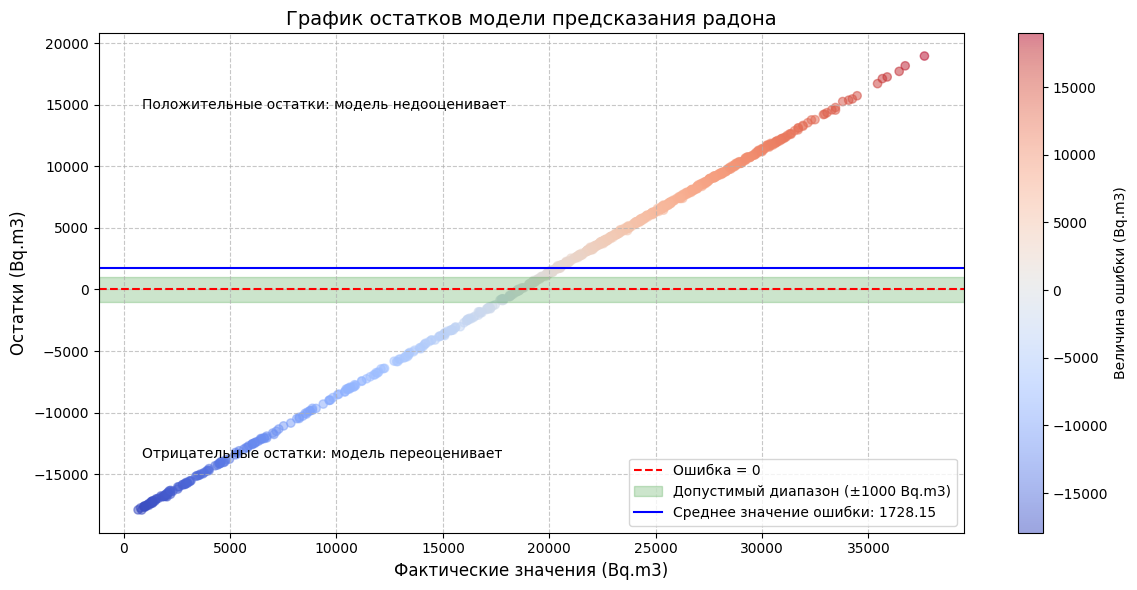

In [25]:
# График остатков
plt.figure(figsize=(12, 6))
scatter = plt.scatter(y_test_inv, errors, alpha=0.5, c=errors, cmap='coolwarm')
plt.axhline(y=0, color='r', linestyle='--', label='Ошибка = 0')
plt.colorbar(scatter, label='Величина ошибки (Bq.m3)')

# Добавляем область для выделения допустимых ошибок (±1000 Bq.m3)
plt.axhspan(-1000, 1000, alpha=0.2, color='green', label='Допустимый диапазон (±1000 Bq.m3)')

plt.title('График остатков модели предсказания радона', fontsize=14)
plt.xlabel('Фактические значения (Bq.m3)', fontsize=12)
plt.ylabel('Остатки (Bq.m3)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Добавляем текст с пояснениями
plt.annotate('Положительные остатки: модель недооценивает',
             xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10)
plt.annotate('Отрицательные остатки: модель переоценивает',
             xy=(0.05, 0.15), xycoords='axes fraction', fontsize=10)

# Отображаем среднее значение ошибки
mean_error = np.mean(errors)
plt.axhline(y=mean_error, color='blue', linestyle='-',
            label=f'Среднее значение ошибки: {mean_error:.2f}')

# Добавляем легенду
plt.legend(loc='best', fontsize=10)

# Улучшаем внешний вид
plt.tight_layout()
plt.show()

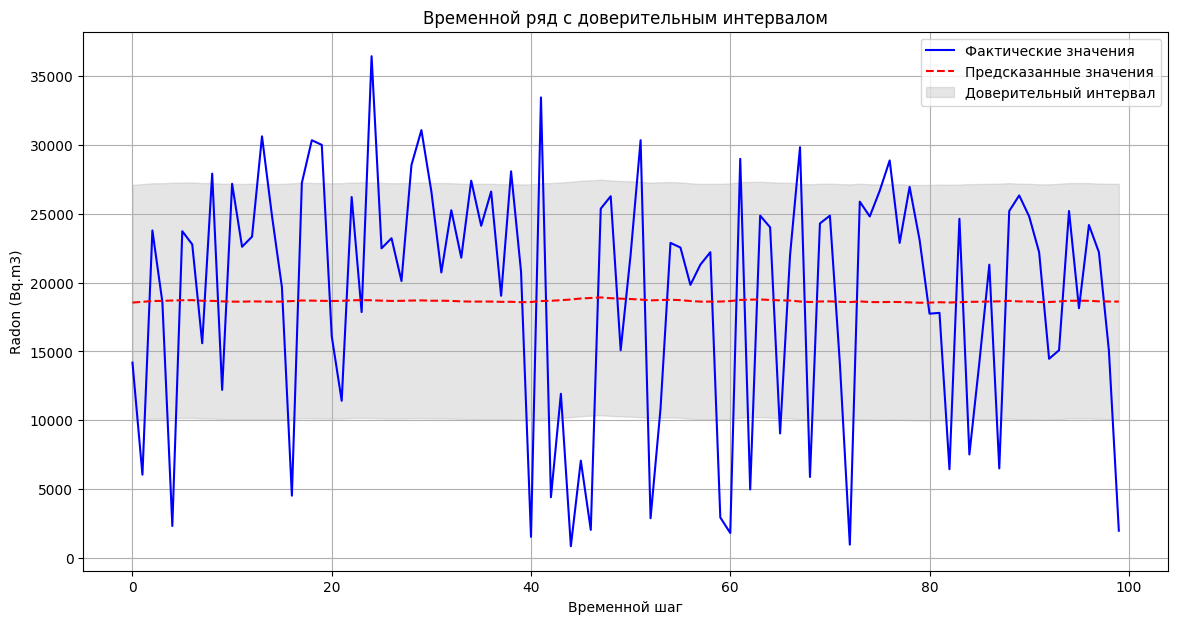

In [26]:
# Визуализация временного ряда с доверительным интервалом
plt.figure(figsize=(14, 7))
# Выборка из 100 точек для лучшей визуализации
sample = slice(0, 100)
plt.plot(y_test_inv[sample], 'b-', label='Фактические значения')
plt.plot(test_pred_inv[sample], 'r--', label='Предсказанные значения')
# Доверительный интервал (условно ±1 стандартное отклонение ошибок)
std_error = np.std(errors)
plt.fill_between(
    range(100),
    test_pred_inv[sample] - std_error,
    test_pred_inv[sample] + std_error,
    color='gray', alpha=0.2, label='Доверительный интервал'
)
plt.title('Временной ряд с доверительным интервалом')
plt.xlabel('Временной шаг')
plt.ylabel('Radon (Bq.m3)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Предполагается, что model, X_test, y_test, и scaler уже определены
# Получение предсказаний модели на тестовых данных
predicted_values = model.predict(X_test)

# Создание массива с той же формой, что и исходные данные
# Заполнение предсказанными значениями только первого столбца (уровень радона)
predicted_values_full = np.zeros((predicted_values.shape[0], X_test.shape[2]))
predicted_values_full[:, 0] = predicted_values[:, 0]

# Обратное преобразование предсказанных значений из нормализованных данных
predicted_values_full = scaler.inverse_transform(predicted_values_full)

# Извлечение только предсказанных значений уровня радона
predicted_radon_values = predicted_values_full[:, 0]

# Обратное преобразование истинных значений из нормализованных данных
true_values_full = np.zeros((y_test.shape[0], X_test.shape[2]))
true_values_full[:, 0] = y_test
true_values_full = scaler.inverse_transform(true_values_full)
true_radon_values = true_values_full[:, 0]

# Предполагается, что test_data - это ваш DataFrame с тестовыми данными и индексом времени
# Убедитесь, что test_data содержит правильный индекс времени
true_radon_series = pd.Series(true_radon_values, index=test_data.index[-len(true_radon_values):])
predicted_radon_series = pd.Series(predicted_radon_values, index=test_data.index[-len(predicted_radon_values):])

# Сортировка данных по индексу
true_radon_series_sorted = true_radon_series.sort_index()
predicted_radon_series_sorted = predicted_radon_series.sort_index()

# Пример использования
plot_true_vs_predicted(true_radon_series_sorted, predicted_radon_series_sorted)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [28]:
model_path = '/content/hybrid_model.h5'  # Путь для сохранения модели
history_path = '/content/training_history.pkl'  # Путь для сохранения истории обучения

In [29]:
# Сохранение модели и истории
save_model(model, model_path)
save_training_history(history, history_path)

Модель сохранена в /content/hybrid_model.h5
История обучения сохранена в /content/training_history.pkl


In [30]:
# Загрузка модели (при необходимости)
# model = load_model(model_path)